# Import Libraries & Dependencies

In [1]:
#import libraries and dependencies

from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix,classification_report,plot_confusion_matrix,accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from mpl_toolkits.mplot3d import Axes3D
from numpy import mean
from numpy import std
import numpy as np
import pandas as pd
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Create connection to postgres database EmployeeSQL
load_dotenv()
my_env_var = os.getenv('DB_CONNECTION_STRING')
engine = create_engine(my_env_var)
connection = engine.connect()
connection

In [3]:
real_estateFinal_df = pd.read_sql('SELECT * FROM "real_estate_final"', connection)
pd.set_option('display.max_columns', None)
real_estateFinal_df.sample(5)

,index,address,neighborhood,borough,bed,bath,days_on_market,compass_property_type,mls_property_subtype,mls_property_type,listed_price,sold_price,sold_date,zipcode,lat,long,year_built,dom_ranges,dom_tier,dom_lowerbound,dom_iqr,dom_upperbound,dom_extended,dom_outlier,walkable_false,walkable_true,health_level_dead,health_level_fair,health_level_good,health_level_poor,ada_access_no,ada_access_yes,ada_access_partial,type_is_active_cleanup_mild_threat,type_is_active_significant_threat,type_is_completed_clean,type_is_maintain_continued_threat,type_is_potential_threat,type_is_felony,type_is_violation,type_is_misdemeanor,danger_level_is_high,danger_level_is_low,lunch_eligibity_high_false_elem,lunch_eligibity_high_true_elem,type_is_top_25th_percentile_elem,type_is_50th_percentile_elem,type_is_75th_percentile_elem,type_is_bottom_25th_percentile_elem,lunch_eligibity_high_false_middle,lunch_eligibity_high_true_middle,type_is_top_25th_percentile_middle,type_is_50th_percentile_middle,type_is_75th_percentile_middle,type_is_bottom_25th_percentile_middle,lunch_eligibity_high_false_high,lunch_eligibity_high_true_high,type_is_top_25th_percentile_high,type_is_50th_percentile_high,type_is_75th_percentile_high,type_is_bottom_25th_percentile_high
11231,11205,122-18 115th ave,south ozone park,queens,2,1.50,35,townhouse,single family,townhouse,519000,490000,2020-02-10,11420,40.6764,-73.8125,2020-01-01,<55,0,1,0,0,0,0,0,400,294,666,4356,178,0,0,0,0,0,0,0,0,106,63,115,15,269,2,4,4,2,0,0,1,2,0,2,1,0,1,0,0,0,0,1
21810,21810,"65-15 alderton st, unit 6d",rego park,queens,2,1.00,111,co-op,co-op,co-op,329000,288000,2020-07-08,11374,40.7256,-73.8625,1964-01-01,105-188,2,0,0,1,0,0,0,393,175,482,2300,127,2,0,0,1,1,2,0,0,22,22,56,4,96,3,1,1,3,0,0,1,0,0,1,0,0,0,0,0,0,0,0
34878,34877,"4665 bedford ave, unit 3b",sheepshead bay,brooklyn,1,1.00,93,condo,0,condo,325000,329550,2020-01-21,11235,40.5860,-73.9419,None,55-105,1,0,1,0,0,0,1,467,394,1276,3228,259,11,1,0,3,0,3,0,0,42,28,60,7,123,2,4,3,2,1,0,1,3,1,2,1,0,2,5,1,0,0,6
36899,36899,650 georgia ave,east new york,brooklyn,6,2.50,407,townhouse,all multi family/two family,townhouse,695000,590000,2020-12-23,11207,40.6710,-73.8940,2001-01-01,388-3140,4,0,0,0,0,1,0,306,341,1387,6564,342,29,1,2,6,0,4,0,0,305,188,278,90,681,1,17,2,1,4,11,1,9,0,2,4,4,0,3,0,0,0,3
36042,36041,917 avenue i,midwood manor,brooklyn,4,2.75,105,townhouse,single family,townhouse,0,1712500,2020-11-24,11230,40.6191,-73.9654,2025-01-01,55-105,1,0,1,0,0,0,0,294,237,1258,5452,389,1,0,1,0,0,1,0,0,95,92,195,37,345,1,3,0,3,1,0,1,1,0,1,1,0,1,0,0,0,1,0


## Random Forest Classifier Model

This model will classify the property type based on all the features selected in the X value.

In [4]:
#assign X values (independent variable) from the Real Estate Final table for the model - cast all as int 
X = real_estateFinal_df[['zipcode', 'sold_price','bed', 'bath', 'days_on_market', 'dom_tier', 'dom_lowerbound', 'dom_iqr', 'dom_upperbound','dom_extended', 
            'dom_outlier', 'walkable_false', 'walkable_true', 'health_level_dead', 'health_level_fair', 'health_level_good',
            'health_level_poor', 'ada_access_no', 'ada_access_yes', 'ada_access_partial', 
            'type_is_active_cleanup_mild_threat','type_is_active_significant_threat','type_is_completed_clean',
            'type_is_maintain_continued_threat', 'type_is_potential_threat', 'type_is_felony', 'type_is_violation', 
            'type_is_misdemeanor', 'danger_level_is_high', 'danger_level_is_low', 'lunch_eligibity_high_false_elem',
            'lunch_eligibity_high_true_elem', 'type_is_top_25th_percentile_elem', 'type_is_50th_percentile_elem',
            'type_is_75th_percentile_elem', 'type_is_bottom_25th_percentile_elem', 'lunch_eligibity_high_false_middle',
            'lunch_eligibity_high_true_middle', 'type_is_top_25th_percentile_middle', 'type_is_50th_percentile_middle',
            'type_is_75th_percentile_middle', 'type_is_bottom_25th_percentile_middle', 'lunch_eligibity_high_false_high',
            'lunch_eligibity_high_true_high', 'type_is_top_25th_percentile_high', 'type_is_50th_percentile_high',
            'type_is_75th_percentile_high', 'type_is_bottom_25th_percentile_high']]

X.astype(int)

,zipcode,sold_price,bed,bath,days_on_market,dom_tier,dom_lowerbound,dom_iqr,dom_upperbound,dom_extended,dom_outlier,walkable_false,walkable_true,health_level_dead,health_level_fair,health_level_good,health_level_poor,ada_access_no,ada_access_yes,ada_access_partial,type_is_active_cleanup_mild_threat,type_is_active_significant_threat,type_is_completed_clean,type_is_maintain_continued_threat,type_is_potential_threat,type_is_felony,type_is_violation,type_is_misdemeanor,danger_level_is_high,danger_level_is_low,lunch_eligibity_high_false_elem,lunch_eligibity_high_true_elem,type_is_top_25th_percentile_elem,type_is_50th_percentile_elem,type_is_75th_percentile_elem,type_is_bottom_25th_percentile_elem,lunch_eligibity_high_false_middle,lunch_eligibity_high_true_middle,type_is_top_25th_percentile_middle,type_is_50th_percentile_middle,type_is_75th_percentile_middle,type_is_bottom_25th_percentile_middle,lunch_eligibity_high_false_high,lunch_eligibity_high_true_high,type_is_top_25th_percentile_high,type_is_50th_percentile_high,type_is_75th_percentile_high,type_is_bottom_25th_percentile_high
0,10011,1646000,1,2,75,1,0,1,0,0,0,0,85,94,195,1769,76,5,2,0,1,0,10,0,1,664,200,924,252,1536,4,0,4,0,0,0,3,0,1,1,1,0,3,4,1,1,1,4
1,10023,799000,1,1,60,1,0,1,0,0,0,0,104,57,375,1756,72,2,2,0,0,0,3,0,0,339,158,971,151,1317,4,0,3,0,1,0,3,0,1,1,0,1,3,3,2,1,0,3
2,10025,670000,1,1,122,2,0,0,1,0,0,0,64,126,576,2796,198,4,1,0,1,0,0,0,0,401,177,891,169,1300,5,1,3,2,0,1,4,3,0,4,2,1,0,0,0,0,0,0
3,10011,2175000,2,3,72,1,0,1,0,0,0,0,85,94,195,1769,76,5,2,0,1,0,10,0,1,664,200,924,252,1536,4,0,4,0,0,0,3,0,1,1,1,0,3,4,1,1,1,4
4,10024,2333000,2,2,134,2,0,0,1,0,0,0,67,80,370,2763,98,3,0,0,0,0,2,0,0,130,78,191,42,357,5,0,5,0,0,0,4,1,3,2,0,0,1,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37223,11235,230000,1,1,105,1,0,1,0,0,0,1,467,394,1276,3228,259,11,1,0,3,0,3,0,0,42,28,60,7,123,2,4,3,2,1,0,1,3,1,2,1,0,2,5,1,0,0,6
37224,11235,2050000,7,5,105,1,0,1,0,0,0,1,467,394,1276,3228,259,11,1,0,3,0,3,0,0,42,28,60,7,123,2,4,3,2,1,0,1,3,1,2,1,0,2,5,1,0,0,6
37225,11235,800000,8,1,105,1,0,1,0,0,0,1,467,394,1276,3228,259,11,1,0,3,0,3,0,0,42,28,60,7,123,2,4,3,2,1,0,1,3,1,2,1,0,2,5,1,0,0,6
37226,11235,940000,8,4,105,1,0,1,0,0,0,1,467,394,1276,3228,259,11,1,0,3,0,3,0,0,42,28,60,7,123,2,4,3,2,1,0,1,3,1,2,1,0,2,5,1,0,0,6


In [5]:
#assign Y value (dependent variable) from the Real Estate Final table for the model
y = real_estateFinal_df[['compass_property_type']]
y.dtypes

compass_property_type    object
dtype: object

In [6]:
#Run test and train of the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [7]:
#Run the Random Forest Classifier and then fit it to the x and y train data - also score the x and y test data
rf = RandomForestClassifier(n_estimators=100, random_state=42, max_features="log2", min_samples_split=3, min_samples_leaf=2)
rf = rf.fit(X_train, y_train.values.ravel())
rf.score(X_test, y_test)

0.8755775222950467

In [8]:
#show the importance of the x features
sorted(zip(rf.feature_importances_, X.columns), reverse=True)

[(0.22937887005945629, 'sold_price'),
 (0.17157503049424774, 'bed'),
 (0.08995516554045549, 'bath'),
 (0.055287598042701926, 'days_on_market'),
 (0.032951357087595105, 'zipcode'),
 (0.026912989427728955, 'health_level_dead'),
 (0.023816581304704453, 'health_level_good'),
 (0.023638720858806653, 'walkable_true'),
 (0.022342969911560862, 'type_is_completed_clean'),
 (0.020196481164870786, 'type_is_misdemeanor'),
 (0.019642908882815273, 'health_level_poor'),
 (0.019560461387406344, 'type_is_active_cleanup_mild_threat'),
 (0.016773650327539826, 'health_level_fair'),
 (0.015653110835225057, 'danger_level_is_low'),
 (0.014505345782316647, 'type_is_violation'),
 (0.013669022328834459, 'type_is_felony'),
 (0.01334061365757357, 'danger_level_is_high'),
 (0.01240146526081054, 'dom_iqr'),
 (0.012025821766744577, 'dom_tier'),
 (0.011765389358064168, 'type_is_bottom_25th_percentile_elem'),
 (0.011210517793339885, 'lunch_eligibity_high_true_elem'),
 (0.010410432394504043, 'type_is_top_25th_percentil

In [9]:
#make prediction from model
y_pred = rf.predict(X_test)

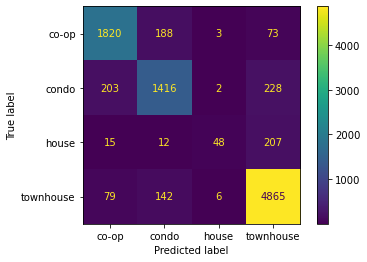

In [10]:
#evaluate the classification made by the model by declaring a confusion matrix
confusion_matrix(y_test, y_pred)
plot_confusion_matrix(rf,X_test,y_test)

In [11]:
#generate a classification report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

       co-op       0.86      0.87      0.87      2084
       condo       0.81      0.77      0.79      1849
       house       0.81      0.17      0.28       282
   townhouse       0.91      0.96      0.93      5092

    accuracy                           0.88      9307
   macro avg       0.85      0.69      0.72      9307
weighted avg       0.87      0.88      0.87      9307



## Random Forest Regression

In [12]:
#assign X values from the Real Estate Final table for the model - cast all as int 
X1 = real_estateFinal_df[['zipcode','bed', 'bath', 'days_on_market', 'dom_tier', 'dom_lowerbound', 'dom_iqr', 'dom_upperbound','dom_extended', 
            'dom_outlier', 'walkable_false', 'walkable_true', 'health_level_dead', 'health_level_fair', 'health_level_good',
            'health_level_poor', 'ada_access_no', 'ada_access_yes', 'ada_access_partial', 
            'type_is_active_cleanup_mild_threat','type_is_active_significant_threat','type_is_completed_clean',
            'type_is_maintain_continued_threat', 'type_is_potential_threat', 'type_is_felony', 'type_is_violation', 
            'type_is_misdemeanor', 'danger_level_is_high', 'danger_level_is_low', 'lunch_eligibity_high_false_elem',
            'lunch_eligibity_high_true_elem', 'type_is_top_25th_percentile_elem', 'type_is_50th_percentile_elem',
            'type_is_75th_percentile_elem', 'type_is_bottom_25th_percentile_elem', 'lunch_eligibity_high_false_middle',
            'lunch_eligibity_high_true_middle', 'type_is_top_25th_percentile_middle', 'type_is_50th_percentile_middle',
            'type_is_75th_percentile_middle', 'type_is_bottom_25th_percentile_middle', 'lunch_eligibity_high_false_high',
            'lunch_eligibity_high_true_high', 'type_is_top_25th_percentile_high', 'type_is_50th_percentile_high',
            'type_is_75th_percentile_high', 'type_is_bottom_25th_percentile_high']]

X1.astype(int)

#assign Y value (dependent variable) from the Real Estate Final table for the model
y1 = real_estateFinal_df[['sold_price']]

In [21]:
#Run test and train of the data
X_train, X_test, y_train, y_test = train_test_split(X1, y1, random_state = 101)

#Run the Random Forest Regression and then fit it to the x and y train data
model = RandomForestRegressor(n_estimators = 2000, max_depth = 150, random_state = 101)
model.fit(X_train, y_train.values.ravel())

RandomForestRegressor(max_depth=150, n_estimators=2000, random_state=101)

In [22]:
#make prediction from model
y1_pred = model.predict(X_test)

pd.set_option('display.float_format', lambda x: '%.3f' % x)
result_regression = X_test
result_regression['sold_price'] = y_test
result_regression['y1_pred'] = y1_pred.tolist()
result_regression.sample(5)

<ipython-input-22-f01f512a3210>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_regression['sold_price'] = y_test
<ipython-input-22-f01f512a3210>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_regression['y1_pred'] = y1_pred.tolist()


,zipcode,bed,bath,days_on_market,dom_tier,dom_lowerbound,dom_iqr,dom_upperbound,dom_extended,dom_outlier,walkable_false,walkable_true,health_level_dead,health_level_fair,health_level_good,health_level_poor,ada_access_no,ada_access_yes,ada_access_partial,type_is_active_cleanup_mild_threat,type_is_active_significant_threat,type_is_completed_clean,type_is_maintain_continued_threat,type_is_potential_threat,type_is_felony,type_is_violation,type_is_misdemeanor,danger_level_is_high,danger_level_is_low,lunch_eligibity_high_false_elem,lunch_eligibity_high_true_elem,type_is_top_25th_percentile_elem,type_is_50th_percentile_elem,type_is_75th_percentile_elem,type_is_bottom_25th_percentile_elem,lunch_eligibity_high_false_middle,lunch_eligibity_high_true_middle,type_is_top_25th_percentile_middle,type_is_50th_percentile_middle,type_is_75th_percentile_middle,type_is_bottom_25th_percentile_middle,lunch_eligibity_high_false_high,lunch_eligibity_high_true_high,type_is_top_25th_percentile_high,type_is_50th_percentile_high,type_is_75th_percentile_high,type_is_bottom_25th_percentile_high,sold_price,y1_pred
16928,11366,3,1.500,243,3,0,0,0,1,0,135,0,91,312,2561,49,0,0,0,0,0,0,0,0,22,16,33,4,67,0,1,0,1,0,0,1,1,0,1,1,0,1,1,0,0,2,0,762500,808329.826
33677,11208,8,4.500,265,3,0,0,0,1,0,0,286,349,1053,6451,392,6,1,0,8,1,7,1,2,280,211,265,69,687,0,12,2,3,3,4,0,9,0,3,1,5,0,4,0,0,0,4,975000,899413.923
5434,10312,3,1.500,215,3,0,0,0,1,0,813,0,830,3594,16691,1071,2,0,0,0,0,2,1,0,5,5,25,1,34,5,0,2,3,0,0,2,0,0,2,0,0,1,0,0,0,1,0,460000,474991.060
513,10025,1,1.000,129,2,0,0,1,0,0,0,64,126,576,2796,198,4,1,0,1,0,0,0,0,401,177,891,169,1300,5,1,3,2,0,1,4,3,0,4,2,1,0,0,0,0,0,0,610000,679173.513
33265,11214,2,1.500,105,1,0,1,0,0,0,0,254,191,536,3512,102,5,2,0,1,0,3,0,1,132,94,234,71,389,1,7,2,5,1,0,1,4,0,4,1,0,1,5,0,1,3,2,705000,485944.837


In [23]:
#score the y test data vs the predicted data
r2 = r2_score(y_test, y1_pred)
r2
print('R-squared scores:', round(r2, 3))

R-squared scores: 0.77


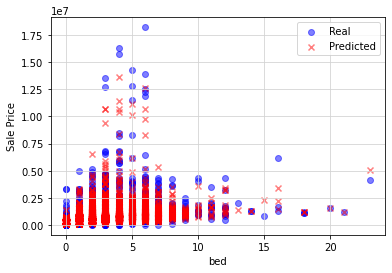

In [24]:
# Define x axis
x_axis = X_test.bed

# Build scatterplot
plt.scatter(x_axis, y_test, c = 'b', alpha = 0.5, marker = 'o', label = 'Real')
plt.scatter(x_axis, y1_pred, c = 'r', alpha = 0.5, marker = 'x', label = 'Predicted')
plt.xlabel('bed')
plt.ylabel('Sale Price')
plt.grid(color = '#D3D3D3', linestyle = 'solid')
plt.legend(loc = 'upper right')
plt.show()

In [25]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Mean absolute error (MAE)
mae = mean_absolute_error(y_test.values.ravel(), y1_pred)

# Mean squared error (MSE)
mse = mean_squared_error(y_test.values.ravel(), y1_pred)

# Print metrics
print('Mean Absolute Error:', round(mae, 2))
print('Mean Squared Error:', round(mse, 2))

Mean Absolute Error: 159173.36
Mean Squared Error: 129323626016.35


In [20]:
### This cell should only be run to perform tuning of the algorithm. One tool used to do this is GridSearchCV method which will obtain the best parameters for the algorithm. Takes forever to run.
from sklearn.model_selection import GridSearchCV

#Find the best parameters for the model
parameters = {
    'max_depth': [70, 80, 90, 100],
    'n_estimators': [900, 1000, 1100]
}
gridforest = GridSearchCV(model, parameters, cv = 3, n_jobs = -1, verbose = 1)
gridforest.fit(X_train, y_train)
gridforest.best_params_

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


KeyboardInterrupt: 

In [26]:
# Get features list
characteristics = X1.columns

In [27]:
# Get the variables importances, sort them, and print the result
importances = list(model.feature_importances_)
characteristics_importances = [(characteristic, round(importance, 2)) for characteristic, importance in zip(characteristics, importances)]
characteristics_importances = sorted(characteristics_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in characteristics_importances];

Variable: bath                 Importance: 0.34
Variable: zipcode              Importance: 0.23
Variable: days_on_market       Importance: 0.08
Variable: type_is_completed_clean Importance: 0.07
Variable: bed                  Importance: 0.06
Variable: health_level_dead    Importance: 0.02
Variable: ada_access_yes       Importance: 0.02
Variable: dom_iqr              Importance: 0.01
Variable: walkable_true        Importance: 0.01
Variable: health_level_fair    Importance: 0.01
Variable: health_level_good    Importance: 0.01
Variable: health_level_poor    Importance: 0.01
Variable: type_is_active_cleanup_mild_threat Importance: 0.01
Variable: type_is_felony       Importance: 0.01
Variable: type_is_violation    Importance: 0.01
Variable: type_is_misdemeanor  Importance: 0.01
Variable: danger_level_is_low  Importance: 0.01
Variable: lunch_eligibity_high_false_elem Importance: 0.01
Variable: lunch_eligibity_high_true_elem Importance: 0.01
Variable: type_is_top_25th_percentile_elem Importa

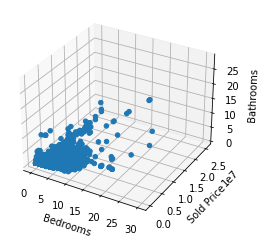

In [28]:
from matplotlib.colors import ListedColormap

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xs = real_estateFinal_df[['bed']]
ys =real_estateFinal_df[['sold_price']]
zs =real_estateFinal_df[['bath']]

cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

ax.scatter(xs, ys, zs, marker='o', cmap=cmap, alpha=1)

ax.set_xlabel('Bedrooms')
ax.set_ylabel('Sold Price')
ax.set_zlabel('Bathrooms')

plt.show()